In [12]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

def normalize_matrix_columns(A):
    column_norms = np.linalg.norm(A, axis=0)
    zero_norms = column_norms == 0
    column_norms[zero_norms] = 1
    normalized_A = A / column_norms
    normalized_A[:, zero_norms] = 0
    return normalized_A

def load_csr_matrix_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        data = file['Matrix/data'][:]
        indices = file['Matrix/indices'][:]
        indptr = file['Matrix/indptr'][:]
        shape = file['Matrix'].attrs['shape']
    return csr_matrix((data, indices, indptr), shape=shape)

def normalize_matrix(A):
    norm = np.linalg.norm(A)
    if norm == 0:
        return A
    return A / norm

def symmetric_nmf(matrix, rank):
    model = NMF(n_components=rank, init='random', random_state=0)
    W = model.fit_transform(matrix)
    H = model.components_
    reconstructed_matrix = np.dot(W, H)
    return reconstructed_matrix

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]
resolution, resolution_label = parse_resolution(resolution_str)

print(f"Extracted resolution: {resolution}, label: {resolution_label}")

methy_file_path = f'{output_directory}/methy_{resolution_label}_outerproduct_dir/chr1/sc12.GCCAAT_outer_product.h5'
hic_path = f'{output_directory}/hic_{resolution_label}_emphasized_correlation_dir/chr1/sc12.GCCAAT_chr1.h5'

with h5py.File(methy_file_path, 'r') as hf:
    dataset_name = list(hf.keys())[0]  
    methy_matrix = hf[dataset_name][:]

# Check for any negative values in the matrix
if np.any(methy_matrix < 0):
    print(f"Warning: The matrix contains negative values.")

# Load the Hi-C matrix
hic_matrix = load_csr_matrix_from_hdf5(hic_path)

# Convert to dense matrix and drop the last row and column
hic_matrix_dense = hic_matrix.toarray()
hic_matrix_dense = hic_matrix_dense[:-1, :-1]

# Update the methy_matrix size to match hic_matrix
methy_matrix = methy_matrix[:hic_matrix_dense.shape[0], :hic_matrix_dense.shape[1]]

# For all zero entries in hic_matrix, make corresponding entries in methy_matrix zero
methy_matrix[hic_matrix_dense == 0] = 0

# Normalize each matrix so that each column has a norm of 1
hic_matrix = normalize_matrix_columns(hic_matrix_dense)
methy_matrix = normalize_matrix_columns(methy_matrix)

# Take the symmetric NMF rank 10 of each matrix
nmf_rank = 10
hic_matrix_nmf = symmetric_nmf(hic_matrix_dense, nmf_rank)
methy_matrix_nmf = symmetric_nmf(methy_matrix, nmf_rank)

# Additional normalization step
hic_matrix_nmf = normalize_matrix(hic_matrix_nmf)
methy_matrix_nmf = normalize_matrix(methy_matrix_nmf)

# Combine both normalized matrices into a tensor
tensor = np.stack((hic_matrix_nmf, methy_matrix_nmf), axis=-1)

# Create the directory if it does not exist
output_tensor_path = f'{output_directory}/combined_{resolution_label}_methy_hic_single_cell_tensor/chr1/sc12.GCCAAT.h5'
os.makedirs(os.path.dirname(output_tensor_path), exist_ok=True)

# Save the tensor to an HDF5 file
with h5py.File(output_tensor_path, 'w') as hf:
    hf.create_dataset('Tensor', data=tensor)

print(f"Tensor saved to {output_tensor_path}")


Resolutions from config: ('1000000:1Mb',)
Extracted resolution: 1000000, label: 1Mb
Tensor saved to ../../projects/single_cell_files/combined_1Mb_methy_hic_single_cell_tensor/chr1/sc12.GCCAAT.h5


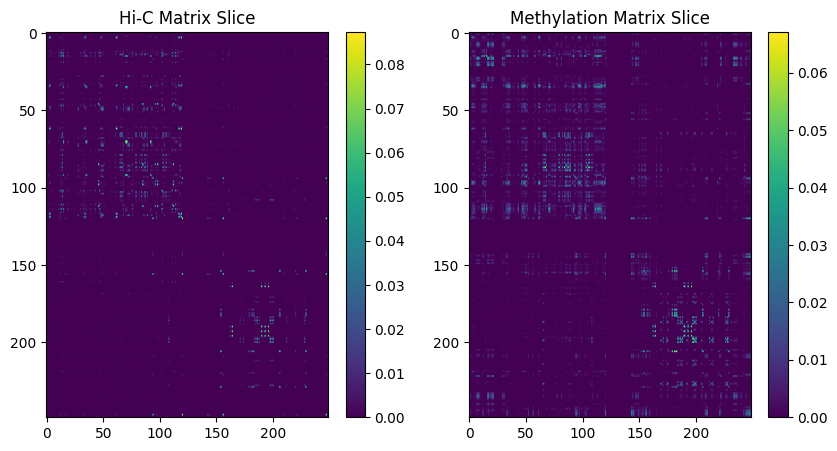

Statistics for Hi-C Matrix:
Shape: (249, 249)
Min: 0.0
Max: 0.08730366887488474
Number of non-zeros: 22312
Norm: 1.0
Norm of each column: [0.00000000e+00 2.76594958e-03 1.81506672e-02 1.83220552e-01
 1.04625779e-02 1.05662769e-02 6.77244954e-04 2.93863743e-03
 4.27586717e-03 2.24368770e-03 0.00000000e+00 2.56354914e-02
 3.23924734e-02 1.21049080e-01 1.04030476e-01 1.59787679e-01
 3.46687150e-03 2.38309830e-02 0.00000000e+00 3.77779277e-02
 3.69829813e-04 2.39931759e-03 0.00000000e+00 1.42884689e-20
 5.24159744e-46 1.42884689e-20 0.00000000e+00 0.00000000e+00
 6.18774045e-02 1.18755837e-03 2.25761083e-02 4.40534146e-03
 2.34800894e-02 3.87676350e-02 1.39736630e-01 1.44097320e-01
 1.93385931e-02 2.11507361e-03 1.24996673e-03 3.33135481e-02
 6.83140448e-04 1.95061196e-14 5.98604899e-42 4.25082541e-02
 0.00000000e+00 0.00000000e+00 1.64643680e-01 9.50274760e-02
 6.67781958e-02 1.09346475e-01 7.17287499e-02 1.94982334e-02
 2.22004397e-03 1.40664201e-53 0.00000000e+00 2.16793966e-42
 1.46721

In [13]:
# Plotting the slices of the tensor
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor[:, :, 0], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Hi-C Matrix Slice')

plt.subplot(1, 2, 2)
plt.imshow(tensor[:, :, 1], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Methylation Matrix Slice')

plt.show()

# Calculating and printing statistics
def matrix_statistics(matrix, name):
    shape = matrix.shape
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    num_nonzeros = np.count_nonzero(matrix)
    norm = np.linalg.norm(matrix)
    column_norms = np.linalg.norm(matrix, axis=0)
    
    print(f"Statistics for {name}:")
    print(f"Shape: {shape}")
    print(f"Min: {min_val}")
    print(f"Max: {max_val}")
    print(f"Number of non-zeros: {num_nonzeros}")
    print(f"Norm: {norm}")
    print(f"Norm of each column: {column_norms}")
    print()

matrix_statistics(tensor[:, :, 0], "Hi-C Matrix")
matrix_statistics(tensor[:, :, 1], "Methylation Matrix")

In [6]:
import h5py
import gzip
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

methy_output_dir = os.path.join(output_directory, f"methy_{resolution_label}_outerproduct_dir")
methy_matrix_path = os.path.join(output_directory, f'b37.autosome.{resolution_label}_interval.add_value.methy.bed.gz')
prefix_file_path = filtered_list

# File to save all tensors
hdf5_filename = os.path.join(methy_output_dir, f"all_chromosomes_methylation_tensor_{resolution_label}.h5")

# Check if the file already exists and skip computations if it does
if os.path.exists(hdf5_filename):
    print(f"File {hdf5_filename} already exists. Skipping all computations.")
else:
    # Ensure the output directory exists
    os.makedirs(methy_output_dir, exist_ok=True)

    # Function to normalize each column of a matrix so that each column has a norm of one.
    def normalize_matrix_columns(A):
        column_norms = np.linalg.norm(A, axis=0)
        if np.any(column_norms == 0):
            raise ValueError("One or more columns have zero norm. Cannot normalize those columns.")
        normalized_A = A / column_norms
        return normalized_A

    # Function to calculate the matrix from a compressed file.
    def calculate_matrix(file_path):
        data = []
        with gzip.open(file_path, 'rt') as file:
            for line in file:
                fields = line.strip().split('\t')
                numerator_indices = range(6, len(fields), 2)
                denominator_indices = range(7, len(fields), 2)
                row_data = []
                for num_idx, denom_idx in zip(numerator_indices, denominator_indices):
                    numerator = float(fields[num_idx])
                    denominator = float(fields[denom_idx])
                    row_data.append(0 if denominator == 0 else numerator / denominator)
                data.append(row_data)
        data_matrix = np.array(data)
        return data_matrix

    # Read chromosome sizes from the chrom_file
    chromosome_lengths = {}
    with open(chrom_file, 'r') as f:
        for line in f:
            chrom, length = line.strip().split()
            chromosome_lengths[chrom] = int(length)

    # Normalize the methylation matrix columns
    methylation_matrix = normalize_matrix_columns(calculate_matrix(methy_matrix_path))
    print(f'methylation matrix shape at resolution {resolution_label}')
    print(methylation_matrix.shape)

    # Calculate bins per chromosome and slice data accordingly
    chromosome_bins = {key: length // resolution for key, length in chromosome_lengths.items()}
    chromosome_data = {}
    start_bin = 0

    for chromosome, bins in chromosome_bins.items():
        end_bin = start_bin + bins
        chromosome_data[chromosome] = methylation_matrix[start_bin:end_bin, :]
        start_bin = end_bin

    # Read prefixes from the file
    with open(prefix_file_path, 'r') as f:
        prefixes = [line.strip() for line in f]

    with h5py.File(hdf5_filename, 'w') as all_chromosomes_file:
        # Loop through each chromosome and process its data
        for chromosome, data in chromosome_data.items():
            num_samples = data.shape[1]  # Number of samples
            outer_product_matrices = []

            # Create directory for the chromosome
            chromosome_dir = os.path.join(methy_output_dir, f"chr{chromosome}")
            os.makedirs(chromosome_dir, exist_ok=True)

            # Compute the outer product for each sample
            for sample_index in range(num_samples):
                vector = data[:, sample_index]
                outer_product_matrix = np.outer(vector, vector)
                outer_product_matrices.append(outer_product_matrix)

                # Save each outer product matrix in its own .h5 file if it doesn't exist
                prefix = prefixes[sample_index]
                individual_matrix_filename = os.path.join(chromosome_dir, f"{prefix}_outer_product.h5")
                if not os.path.exists(individual_matrix_filename):
                    with h5py.File(individual_matrix_filename, 'w') as individual_matrix_file:
                        individual_matrix_file.create_dataset(f"chr_{chromosome}", data=outer_product_matrix, compression="gzip")

            # Stack all the matrices into a tensor
            tensor = np.stack(outer_product_matrices, axis=0)

            # Transpose the tensor to put the sample index as the third dimension
            tensor_transposed = tensor.transpose((1, 2, 0))

            # Save the transposed tensor to the collective HDF5 file
            all_chromosomes_file.create_dataset(f"chr{chromosome}", data=tensor_transposed, compression="gzip")

            # Also save to an individual HDF5 file for this chromosome if it doesn't exist
            individual_hdf5_filename = os.path.join(chromosome_dir, f"chr{chromosome}_tensor_methylation.h5")
            if not os.path.exists(individual_hdf5_filename):
                with h5py.File(individual_hdf5_filename, 'w') as individual_chromosome_file:
                    individual_chromosome_file.create_dataset(f"chr_{chromosome}", data=tensor_transposed, compression="gzip")

            print(f"Saved tensor for chromosome {chromosome} in both collective and individual HDF5 files.")

# Function to normalize each column of a matrix so that each column has a norm of one.
def normalize_matrix_columns(A):
    column_norms = np.linalg.norm(A, axis=0)
    # Avoid division by zero by setting zero norms to 1 temporarily
    zero_norms = column_norms == 0
    column_norms[zero_norms] = 1
    normalized_A = A / column_norms
    # Restore zero columns to zeros
    normalized_A[:, zero_norms] = 0
    return normalized_A

def load_csr_matrix_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        data = file['Matrix/data'][:]
        indices = file['Matrix/indices'][:]
        indptr = file['Matrix/indptr'][:]
        shape = file['Matrix'].attrs['shape']  # Assuming shape is stored as an attribute
    return csr_matrix((data, indices, indptr), shape=shape)

# Read chromosome sizes from the chrom_file
chromosome_lengths = {}
with open(chrom_file, 'r') as f:
    for line in f:
        chrom, length = line.strip().split()
        chromosome_lengths[chrom] = int(length)

chromosome_bins = {key: length // resolution for key, length in chromosome_lengths.items()}

# Read prefixes from the file
with open(prefix_file_path, 'r') as f:
    prefixes = [line.strip() for line in f]

for chromosome, bins in chromosome_bins.items():
    for prefix in prefixes:
        methy_file_path = f'{output_directory}/methy_{resolution_label}_outerproduct_dir/chr{chromosome}/{prefix}_outer_product.h5'
        hic_path = f'{output_directory}/hic_{resolution_label}_correlation_dir/chr{chromosome}/{prefix}_chr{chromosome}.h5'

        if not os.path.exists(methy_file_path) or not os.path.exists(hic_path):
            print(f"Files {methy_file_path} or {hic_path} do not exist. Skipping.")
            continue

        with h5py.File(methy_file_path, 'r') as hf:
            dataset_name = list(hf.keys())[0]  
            methy_matrix = hf[dataset_name][:]
        
        # Check for any negative values in the matrix
        if np.any(methy_matrix < 0):
            print(f"Warning: The matrix contains negative values.")

        # Load the Hi-C matrix
        hic_matrix = load_csr_matrix_from_hdf5(hic_path)

        # Convert to dense matrix and drop the last row and column
        hic_matrix_dense = hic_matrix.toarray()
        hic_matrix_dense = hic_matrix_dense[:-1, :-1]

        # Update the methy_matrix size to match hic_matrix
        methy_matrix = methy_matrix[:hic_matrix_dense.shape[0], :hic_matrix_dense.shape[1]]

        # For all zero entries in hic_matrix, make corresponding entries in methy_matrix zero
        methy_matrix[hic_matrix_dense == 0] = 0

        # Normalize each matrix so that each matrix has a norm of 1
        hic_matrix_dense = normalize_matrix_columns(hic_matrix_dense)
        methy_matrix = normalize_matrix_columns(methy_matrix)

        # Combine both normalized matrices into a tensor
        tensor = np.stack((hic_matrix_dense, methy_matrix), axis=-1)

        # Create the directory if it does not exist
        output_tensor_path = f'{output_directory}/combined_{resolution_label}_methy_hic_single_cell_tensor/chr{chromosome}/{prefix}.h5'
        os.makedirs(os.path.dirname(output_tensor_path), exist_ok=True)

        # Save the tensor to an HDF5 file
        with h5py.File(output_tensor_path, 'w') as hf:
            hf.create_dataset('Tensor', data=tensor)

        print(f"Tensor saved to {output_tensor_path}")

        # Plotting the slices of the tensor
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tensor[:, :, 0], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f'Hi-C Matrix Slice - {chromosome} - {prefix}')

        plt.subplot(1, 2, 2)
        plt.imshow(tensor[:, :, 1], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f'Methylation Matrix Slice - {chromosome} - {prefix}')

        plt.show()

        # Calculating and printing statistics
        def matrix_statistics(matrix, name):
            shape = matrix.shape
            min_val = np.min(matrix)
            max_val = np.max(matrix)
            num_nonzeros = np.count_nonzero(matrix)
            norm = np.linalg.norm(matrix)
            column_norms = np.linalg.norm(matrix, axis=0)

            print(f"Statistics for {name}:")
            print(f"Shape: {shape}")
            print(f"Min: {min_val}")
            print(f"Max: {max_val}")
            print(f"Number of non-zeros: {num_nonzeros}")
            print(f"Norm: {norm}")
            print(f"Norm of each column: {column_norms}")
            print()

        matrix_statistics(hic_matrix_dense, f"Hi-C Matrix - {chromosome} - {prefix}")
        matrix_statistics(methy_matrix, f"Methylation Matrix - {chromosome} - {prefix}")


Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
File ../../projects/single_cell_files/methy_1Mb_outerproduct_dir/all_chromosomes_methylation_tensor_1Mb.h5 already exists. Skipping all computations.
Files ../../projects/single_cell_files/methy_1Mb_outerproduct_dir/chrchr1/sc11.ACTTGA_outer_product.h5 or ../../projects/single_cell_files/hic_1Mb_correlation_dir/chrchr1/sc11.ACTTGA_chrchr1.h5 do not exist. Skipping.
Files ../../projects/single_cell_files/methy_1Mb_outerproduct_dir/chrchr1/sc11.CGATGT_outer_product.h5 or ../../projects/single_cell_files/hic_1Mb_correlation_dir/chrchr1/sc11.CGATGT_chrchr1.h5 do not exist. Skipping.
Files ../../projects/single_cell_files/methy_1Mb_outerproduct_dir/chrchr1/sc11.GCCAAT_outer_product.h5 or ../../projects/single_cell_files/hic_1Mb_correlation_dir/chrchr1/sc11.GCCAAT_chrchr1.h5 do not exist. Skipping.
Files ../../projects/single_cell_files/methy_1Mb_outerproduct_dir/chrchr1/sc11.TAGCTT_outer_product.h5 or ../../p